#### Evaluation

In [1]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt

# Import MD-RNN from mdrnn.py
import rmdn as rmdn
importlib.reload(rmdn)

# Import Utility Functions from utils.py
import utils
importlib.reload(utils)

# Import Dataset from decision_dataset.py
import decision_dataset
importlib.reload(decision_dataset)

# Determine device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Default training loop parameters
TRAINING_PARAMS = {
    'hidden_size': 64,
    'initial_learning_rate': 0.001,
    'min_lr': 1e-5,
    'num_epochs': 100,
    'batch_size': 32
}

2025-06-13 12:15:44,991 - INFO - Using device: cpu.
2025-06-13 12:15:44,992 - INFO - Using device: cpu.
2025-06-13 12:15:44,992 - INFO - Using device: cpu.
2025-06-13 12:15:44,993 - INFO - Using device: cpu.


cpu


#### Load Model

In [27]:
model = rmdn.RMDN(TRAINING_PARAMS['hidden_size'], input_size=2)
model.load_state_dict(torch.load('weights/model_weights_epoch_64_hidden_size_64', weights_only=True))
dataset = decision_dataset.DecisionDataset(generate=True, num_samples=8192)

if device != 'cpu':
    model = model.to(device)

2025-06-13 12:22:42,000 - INFO - Initialized Dataset in GENERATE mode with 8192 samples.


#### Evaluate Model Performance

In [4]:
def visualize_mixture_components(pi, mu, sigma, output, time, prob):
    fig, axes = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'e)']], layout='constrained')
    
    fig.suptitle(f'Mixture Density Output, Probability = {prob}')

    pi = pi.squeeze(0)
    mu = mu.squeeze(0).squeeze(-1)
    sigma = sigma.squeeze(0).squeeze(-1)
    output = output.squeeze(0).squeeze(-1)[:-1]

    axes['a)'].plot(time, mu[:, 0], label=rf'$\mu$', color='blue')
    axes['a)'].fill_between(time, mu[:, 0] - sigma[:, 0], mu[:, 0] + sigma[:, 0], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['a)'].set_title('Gaussian One')

    axes['b)'].plot(time, mu[:, 1], label=rf'$\mu$', color='blue')
    axes['b)'].fill_between(time, mu[:, 1] - sigma[:, 1], mu[:, 1] + sigma[:, 1], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['b)'].set_title('Gaussian Two')

    axes['c)'].plot(time, mu[:, 2], label=rf'$\mu$', color='blue')
    axes['c)'].fill_between(time, mu[:, 2] - sigma[:, 2], mu[:, 2] + sigma[:, 2], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['c)'].set_title('Gaussian Three')

    axes['d)'].plot(time, pi[:, 0], label='Mixture One')
    axes['d)'].plot(time, pi[:, 1], label='Mixture Two')
    axes['d)'].plot(time, pi[:, 2], label='Mixture Three')
    axes['d)'].set_title('Mixture Weights')
    axes['d)'].legend()

    axes['e)'].plot(time, output, label='Output')
    axes['e)'].set_title('Output')

    plt.show()

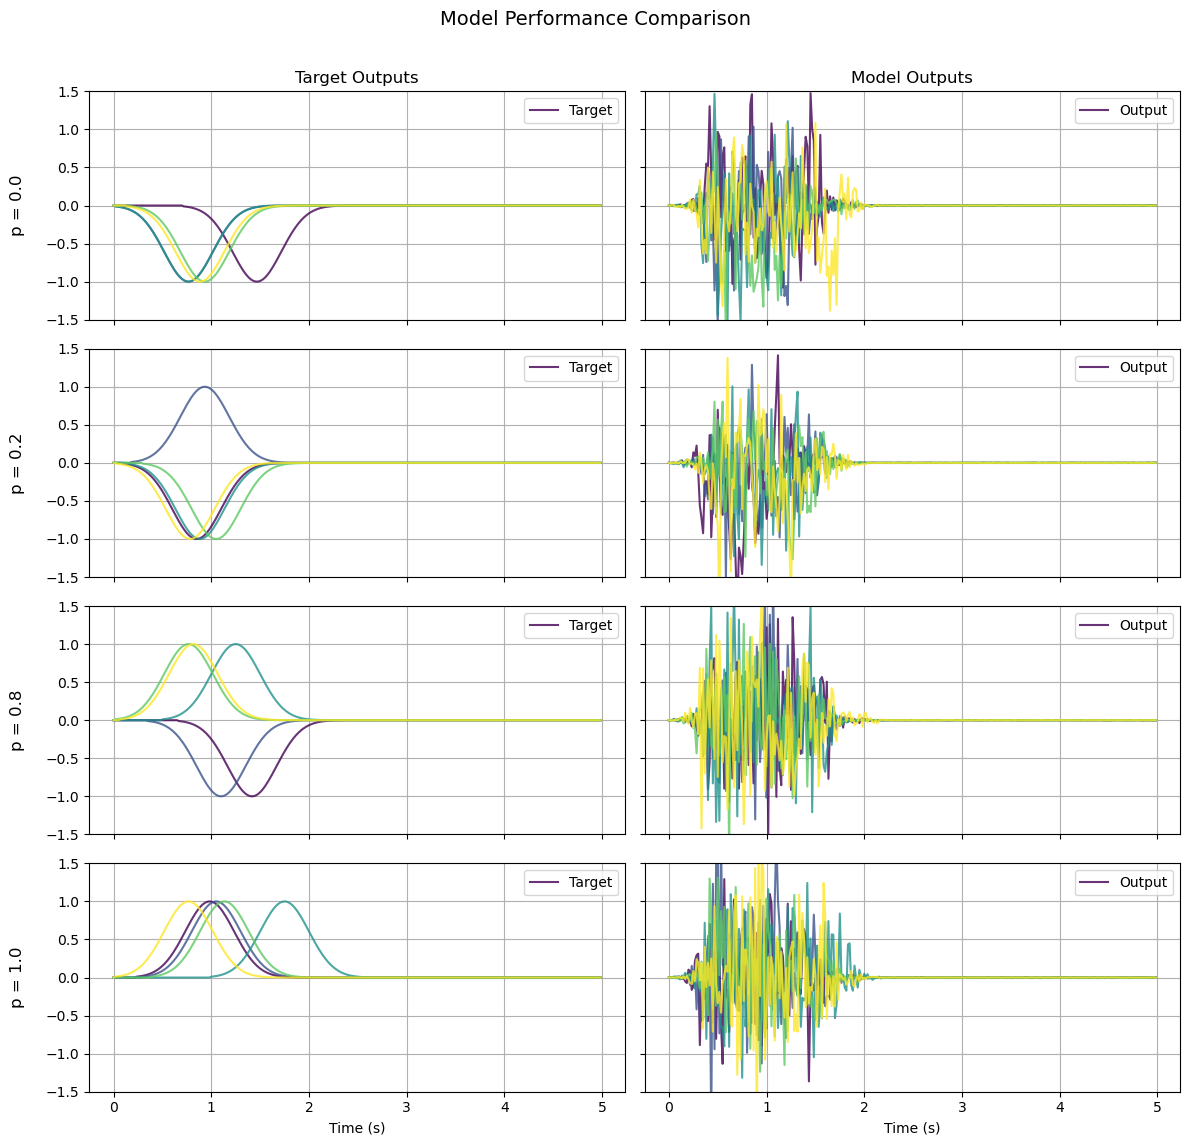

In [28]:
utils.visualize_performance(model, dataset, [0.0, 0.2, 0.8, 1.0], 5)

2025-06-13 12:23:03,159 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


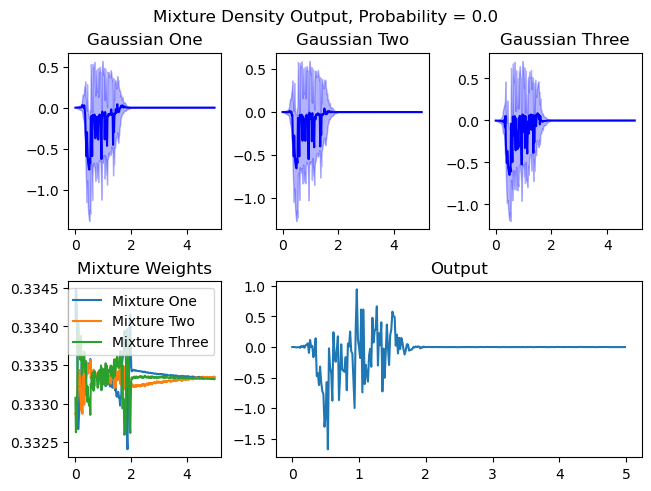

torch.Size([300, 2])


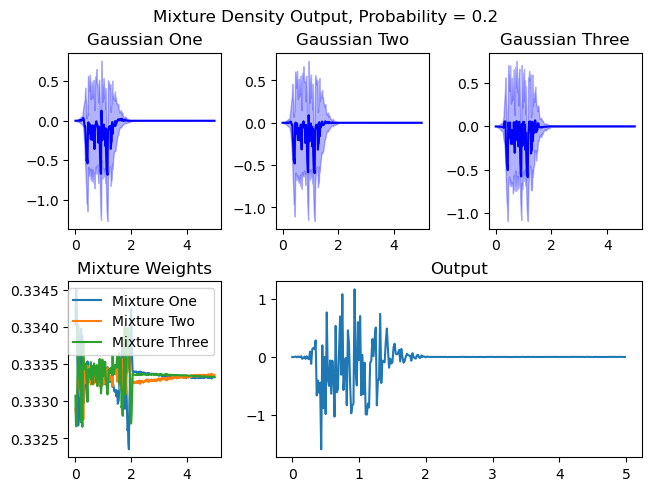

torch.Size([300, 2])


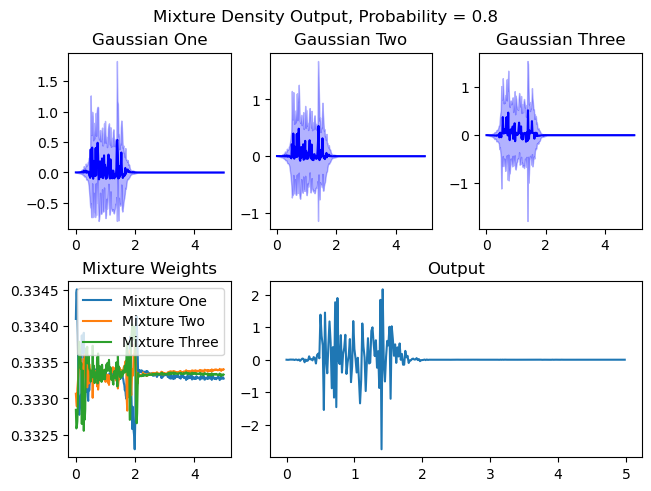

torch.Size([300, 2])


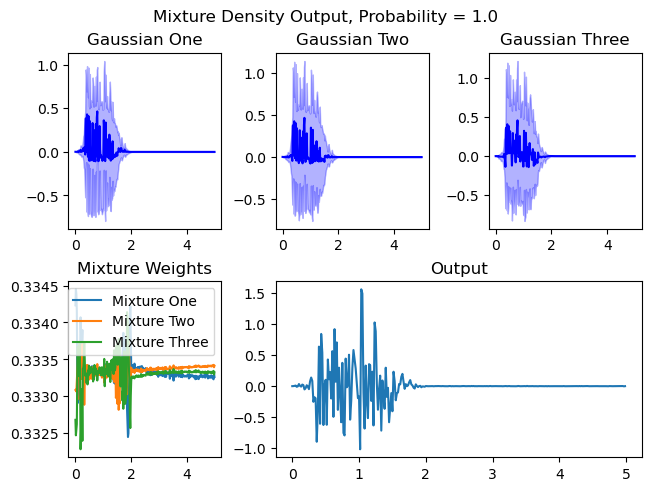

In [29]:
with torch.no_grad():
    model.eval()
    viz_dataset = decision_dataset.DecisionDataset(generate=True, num_samples=64)
    for p in [0.0, 0.2, 0.8, 1.0]:
        inputs, _ = viz_dataset.__getitem__(index=None, p=p)
        print(inputs.shape)
        inputs = inputs.unsqueeze(0)
        pi, mu, sigma, output = model(inputs, train=False)
        visualize_mixture_components(pi, mu, sigma, output, viz_dataset.time, p)